In [23]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing
from matplotlib import pyplot as plt
from sklearn import metrics

In [2]:
# If TPU is available
try:
    # Detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())

except:
    tpu = None
    

# If TPU is defined
if tpu:
    # Initialise TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Instantiate a TPU distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    # Or instanstiate available strategy
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
SEED = 123

# Specify class names
class_names = ["no", "sphere", "vort"]

# Set number of classes
CLASS_NUM = len(class_names)

BATCH_SIZE = 32
EPOCH_NUM = 100

In [4]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/deep-lense/deeplense/dataset/"

def import_dataset(dir_path, class_names):

    # Prepare empty lists to collect features and labels
    features = []
    labels = []

    for class_name in class_names:
        for file in os.listdir(dir_path + class_name):
        
            # Read in numpy array
            arr = np.load(dir_path + class_name + "/" + file)
        
            # Append features to list
            features.append(arr)
            # Append label to list
            labels.append(class_name)
        
    # Convert and reshape features
    X = np.array(features).reshape(-1, 150, 150, 1)
    # Convert and one-hot encode labels
    y = pd.get_dummies(np.array(labels))
    
    return X, y

# Import train set
X_train, y_train = import_dataset(base_dir + "train/", class_names)
# Import devel set
X_devel, y_devel = import_dataset(base_dir + "val/", class_names)

In [7]:
print(f"Size of Train Set: {X_train.shape[0]}")
print(f"Size of Devel Set: {X_devel.shape[0]}")
print(f"Input shape: {X_train.shape[1:]}")

Size of Train Set: 30000
Size of Devel Set: 7500
Input shape: (150, 150, 1)


In [8]:
# Convert train and devel sets to tensor datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
devel_ds = tf.data.Dataset.from_tensor_slices((X_devel, y_devel))

# Improve performance of train set
train_ds = train_ds \
    .cache() \
    .shuffle(buffer_size=len(y_train), seed=SEED) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

# Improve performance of devel set
devel_ds = devel_ds \
    .batch(BATCH_SIZE) \
    .cache() \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# Set up model within scope of tpu strategy
with strategy.scope():

    model = keras.Sequential([
        
        # Augmentation Block
        # preprocessing.RandomFlip("horizontal"),
        # preprocessing.RandomContrast(0.5),

        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding="same"),
        layers.MaxPool2D(),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
        layers.MaxPool2D(),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
        layers.MaxPool2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(units=6, activation="relu"),
        layers.Dense(units=3, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

In [16]:
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=30,
    verbose=True,
)

history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - categorical_accuracy: 0.3347 - loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - categorical_accuracy: 0.3290 - loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - categorical_accuracy: 0.3317 - loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - categorical_accuracy: 0.3301 - loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_loss: 1.0986
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - categorical_accuracy: 0.3337 - loss: 1.0986 - val_categorical_accuracy: 0.3333 - val_loss: 1.0987
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - categorical_accuracy: 0.3308 - loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_loss: 1.0986
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - categorical_accuracy

<Axes: title={'center': 'Accuracy'}>

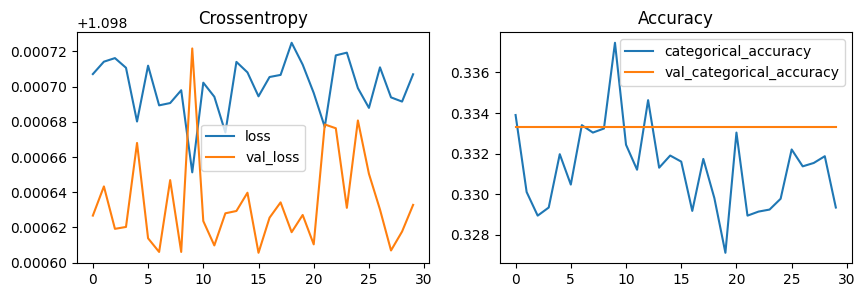

In [18]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["categorical_accuracy", "val_categorical_accuracy"]].plot(title="Accuracy", ax=axes[1])

In [25]:
def eval_auc(y_true, y_pred, ax, title):
    
    # Define metrics
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred)
    # Compute AUC score
    auc_score = metrics.auc(fpr, tpr)
    
    # Create ROC curve
    ax.plot(fpr, tpr)
    
    ax.set_title(f"{title}, AUC: {auc_score:.2f}")
    
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

In [29]:
y_train_pred = model.predict(X_train)
y_devel_pred = model.predict(X_devel)

938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [31]:
y_devel_pred

array([[0.3357124 , 0.33188558, 0.33240205],
       [0.3357124 , 0.33188558, 0.33240205],
       [0.3357124 , 0.33188558, 0.33240205],
       ...,
       [0.3357124 , 0.33188558, 0.33240205],
       [0.3357124 , 0.33188558, 0.33240205],
       [0.3357124 , 0.33188558, 0.33240205]], dtype=float32)

ValueError: multilabel-indicator format is not supported

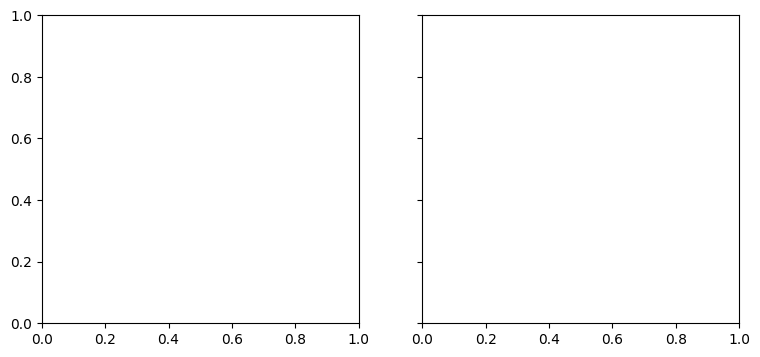

In [32]:
#y_train_pred = model.predict(X_train).flatten()
#y_devel_pred = model.predict(X_devel).flatten()

fig, axes = plt.subplots(1, 2, sharey=True)

fig.set_figheight(4)
fig.set_figwidth(9)

eval_auc(y_train, y_train_pred, axes[0], "Train Set")
eval_auc(y_devel, y_devel_pred, axes[1], "Devel Set")

plt.tight_layout()